# Development Notebook for extracting icebergs from DEMs

by Jessica Scheick

Workflow based on previous methods and code developed by JScheick for Scheick et al 2019 *Remote Sensing*.

***Important note about CRS handling*** This code was developed while also learning about Xarray, rioxarray, rasterio, and other Python geospatial libraries. Since projections are not yet fully handled [smoothly] in any of those resources, and especially not integrated, there's little to no built in checking or handling of CRS. Instead, handling is done manually throughout the code and external to this notebook. This is critical to know because the CRS displayed by a rioxarray dataset may be from one variable added to the dataset, but is not necessarily the original (or read in) CRS for each variable in the dataset (hence the manual, external handling). The `get_mask` and `get_new_var_from_file` methods should reproject new data sources before adding them to the dataset.

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
%matplotlib inline
import hvplot.xarray
# import hvplot.pandas
import holoviews as hv
hv.extension('bokeh','matplotlib')
from holoviews import dim, opts
import datetime as dt
import os
import panel as pn
pn.extension()
import pyproj
import rioxarray

In [ ]:
%load_ext autoreload
# from icebath.core import berggdf as bdf
import icebath as icebath
from icebath.core import build_xrds
from icebath.utils import raster_ops as raster_ops
from icebath.utils import vector_ops as vector_ops
from icebath.core import fl_ice_calcs as icalcs
from icebath.core import build_gdf
%autoreload 2

In [ ]:
# laptop dask setup (perhaps not utilizing all cores?) also, figure out how to connect to existing cluster
import dask
from dask.distributed import Client
client = Client(processes=False)
client

In [ ]:
# laptop dask setup (updated?)
import dask
from dask.distributed import Client, LocalCluster
cluster=LocalCluster()
client = Client(cluster, processes=False)
client

In [ ]:
# Pangeo dask setup
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
# options = cluster.gateway.cluster_options()
# options
# cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()
client

In [ ]:
# reconnect to existing cluster
from dask_gateway import Gateway
g = Gateway()
g.list_clusters()
cluster = g.connect(g.list_clusters()[0].name)
cluster
cluster.scale(0)
client = cluster.get_client()

In [ ]:
cluster.scale(5)

In [ ]:
client

In [ ]:
client.get_versions(check=True)

In [ ]:
cluster.close()

## Read in DEMs and apply corrections (tidal, geoid)

In [ ]:
#Ilulissat Isfjord Mouth, resampled to 50m using CHANGES
# ds = build_xrds.xrds_from_dir('/home/jovyan/icebath/notebooks/supporting_docs/Elevation/ArcticDEM/Regridded_50m_tiles/n69w052/', fjord="JI")

# Ilulissat Isfjord Mouth, original 2m (the files from CHANGES seem much smaller than those from Kane/Pennell. 
# data = xr.open_rasterio('/home/jovyan/icebath/notebooks/supporting_docs/Elevation/ArcticDEM/2m_tiles/n69w052/SETSM_W1W1_20100813_102001000E959700_102001000ECB6B00_seg1_2m_v3.0_dem.tif')
ds = build_xrds.xrds_from_dir('/Users/jessica/projects/bathymetry_from_bergs/DEMs/2m/', fjord="JI")
# ds = build_xrds.xrds_from_dir('/Users/jessica/projects/bathymetry_from_bergs/DEMs/Kane/', fjord="KB", metastr="_meta")
# ds = build_xrds.xrds_from_dir('/home/jovyan/icebath/notebooks/supporting_docs/Elevation/ArcticDEM/2m_tiles/', fjord="JI")

In [ ]:
scrolldem = ds['elevation'].hvplot.image(x='x', y='y',datashade=False, rasterize=True, aspect='equal', cmap='magma', dynamic=True,
                       xlabel="x (km)", ylabel="y (km)", colorbar=True) #turn off datashade to see hover values + colorbar
scrolldem

### Get and Apply Land Mask
**Note: requires a shapefile of the land areas in the ROI**

The default is to use a shapefile of Greenland: `shpfile='/home/jovyan/icebath/notebooks/supporting_docs/Land_region.shp'`, but an alternative file can be specified.

Underlying code is based on: https://gis.stackexchange.com/questions/357490/mask-xarray-dataset-using-a-shapefile
Other results used rioxarray (which isn't on my current working environment), and my previous work did it all manually with gdal.

In [ ]:
# ds.bergxr.get_mask(req_dim=['x','y'], req_vars=None, name='land_mask')
ds.bergxr.get_mask(req_dim=['x','y'], req_vars=None, name='land_mask', 
#                    shpfile='/home/jovyan/icebath/notebooks/supporting_docs/Land_region.shp')
                 shpfile='/Users/jessica/mapping/shpfiles/Greenland/Land_region/Land_region.shp')
# ds.land_mask.plot()
ds['elevation'] = ds['elevation'].where(ds.land_mask == True)

***Potential improvement***
consider not keeping the landmask polygon as an attribute -- this should be implemented in code, needs to be tested

### Apply Geoid Correction
ArcticDEMs come as ellipsoidal height. They are corrected to geoidal height according to geoid_ht = ellipsoid - geoid_offset where geoid_offset is taken from BedMachine v3 and resampled in Xarray (using default "linear" interpolation for multidimensional arrays) to the resolution and extent of the region's dataset.

In [ ]:
ds = ds.bergxr.to_geoid(source='/Users/jessica/mapping/datasets/160281892/BedMachineGreenland-2017-09-20_3413_'+ds.attrs['fjord']+'.nc')
# ds = ds.bergxr.to_geoid(source='/home/jovyan/icebath/notebooks/supporting_docs/160281892/BedMachineGreenland-2017-09-20_'+ds.attrs['fjord']+'.nc')

### Apply Tidal Correction

Uses Tyler Sutterly's pyTMD library

In [ ]:
# model_path='/home/jovyan/pyTMD/models'
model_path='/Users/jessica/computing/tidal_model_files'
ds=ds.bergxr.tidal_corr(loc=[ds.attrs["fjord"]], model_path=model_path)

In [ ]:
# # test to make sure that if you already have a tidal correction it won't reapply it, and test that it will return the tides if you don't have an elevation entered
# ds=ds.bergxr.tidal_corr(loc=["JI"])
# ds=ds.bergxr.tidal_corr(loc=["JI"]) # results in assertion error

# ds.attrs['offset_names'] = ('random')
# ds=ds.bergxr.tidal_corr(loc=["JI"]) # results in longer attribute list

In [ ]:
# # go directly to icalcs function, called under the hood above, if you want to see plots
# tides = icalcs.predict_tides(loc='JI',img_time=ds.dtime.values[0], model_path='/home/jovyan/pyTMD/models',
#                     model='AOTIM-5-2018', epsg=3413, plot=True)
# tides[2]

In [ ]:
ds

## Extract Icebergs from DEM and put into Geodataframe

Completely automated iceberg delineation in the presence of clouds and/or data gaps (as is common in a DEM) is not yet easily implemented with existing methods. Many techniques have been refined for specific fjords or types of situations. Here, we tailor our iceberg detection towards icebergs that will provide reliable water depth estimates. The following filters are applied during the iceberg extraction process:
 - a minimum iceberg horizontal area is specified on a per-fjord basis. These minima are based on icebergs used to infer bathymetry in previous work (Scheick et al 2019).
 - a maximum allowed height for the median freeboard is specified on a per-fjord basis. These maxima are determined as 10% of the [largest] grounded ice thickness for the source glaciers. While the freeboard values from the DEM are later filtered to remove outliers in determining water depth, this filtering step during the delineation process removes "icebergs" where low clouds, rather than icebergs, are the surface represented in the DEM.
 - a maximum iceberg horizontal area of 1000000 m2 (1km2) is assumed to eliminate large clusters of icebergs, melange, and/or cloud picked up by the delineation algorithm.
 - the median freeboard must be greater than 15 m relative to [adjusted] sea level. If not, we can assume the iceberg is either a false positive (e.g. cloud or sea ice) or too small to provide a meaningful water depth estimate.


***Potential improvement***
rechunk the underlying dataset to use the multiple workers on multiple DEMs at once (reduce their in-memory size by making them sparse or removing nan rows)

In [ ]:
# %%timeit -n 1 -r 1
# 3min 17s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
# gdf=None
gdf = build_gdf.xarray_to_gdf(ds)

In [ ]:
# gdf.loc[((gdf['sl_adjust']>4.27) & (gdf['sl_adjust']<4.36))].groupby('date').berg_poly.plot()
gdf.groupby('date').berg_poly.plot()

In [ ]:
# This requires geoviews be installed, and their install pages have warning if your environment uses conda-forge
# libraries and it won't resolve the environment with a conda install, so I'll need to create a new test env to try this
# bergs = gdf.hvplot()
# bergs

In [ ]:
# scrolldems*bergs

## Compute Water Depths on Icebergs

In [ ]:
gdf.berggdf.calc_filt_draft()

In [ ]:
gdf.berggdf.calc_rowwise_medmaxmad('filtered_draft')

In [ ]:
gdf.berggdf.wat_depth_uncert('filtered_draft')

In [ ]:
# def mmm(vals): # mmm = min, med, max
#     print(np.nanmin(vals))
#     print(np.nanmedian(vals))
#     print(np.nanmax(vals))

## Extract measured values from BedMachine v3 and IBCAOv4 (where available)
All bathymetry values from these gridded products are included, then later parsed into bathymetric observations and inferred (from e.g. gravimetry, modeling) for comparing with iceberg-inferred water depths.

Note that the datasets are subset to the region of the fjord outside this script to reduce memory requirements during processing.

***Improvement: add CRS handling/checks to catch when a measurement dataset is incompatible and needs to be reprojected***

#### BedMachine Greenland

In [ ]:
# measfile='/Users/jessica/mapping/datasets/160281892/BedMachineGreenland-2017-09-20.nc'
measfile='/Users/jessica/mapping/datasets/160281892/BedMachineGreenland-2017-09-20_3413_'+ds.attrs['fjord']+'.nc'
# measfile='/home/jovyan/icebath/notebooks/supporting_docs/160281892/BedMachineGreenland-2017-09-20.nc'
# measfile='/home/jovyan/icebath/notebooks/supporting_docs/160281892/BedMachineGreenland-2017-09-20_'+ds.attrs['fjord']+'.nc'

In [ ]:
gdf.berggdf.get_meas_wat_depth(ds, measfile, 
                               vardict={"bed":"bmach_bed", "errbed":"bmach_errbed", "source":"bmach_source"},
                               nanval=-9999)

In [ ]:
bds = (-243983.8540184634, -2266766.2287146077, -243610.84332808948, -2266448.7114776378)

In [ ]:
subset_raster = ds.rio.clip_box(-244983.8540184634, -2276966.2287146077, -243010.84332808948, -2266048.7114776378, auto_expand=True, auto_expand_limit=15)

In [ ]:
ds.sel({"x":-243983.8540184634}, method="nearest")

In [ ]:
%matplotlib inline
ds.bmach_bed.plot()

In [ ]:
ds

#### IBCAOv4
https://www.gebco.net/data_and_products/gridded_bathymetry_data/arctic_ocean/

Source keys: https://www.gebco.net/data_and_products/gridded_bathymetry_data/gebco_2020/

Downloaded Feb 2021

**NOTE** IBCAO has it's own Polar Stereo projection (EPSG:3996: WGS 84/IBCAO Polar Stereographic) so it needs to be reprojected before being applied to these datasets.
See: https://spatialreference.org/ref/?search=Polar+Stereographic

In [ ]:
# measfile2a='/Users/jessica/mapping/datasets/IBCAO_v4_200m_ice_3413.nc'
measfile2a='/Users/jessica/mapping/datasets/IBCAO_v4_200m_ice_3413_'+ds.attrs['fjord']+'.nc'
# measfile2a='/home/jovyan/icebath/notebooks/supporting_docs/IBCAO_v4_200m_ice_3413.nc'
# measfile2a='/home/jovyan/icebath/notebooks/supporting_docs/IBCAO_v4_200m_ice_3413_'+ds.attrs['fjord']+'.nc'
measfile2b='/Users/jessica/mapping/datasets/IBCAO_v4_200m_TID_3413.nc'
# measfile2b='/home/jovyan/icebath/notebooks/supporting_docs/IBCAO_v4_200m_TID_3413.nc'

In [ ]:
gdf.berggdf.get_meas_wat_depth(ds, measfile2a, 
                               vardict={"z":"ibcao_bed"}) # no associated uncertainties
gdf.berggdf.get_meas_wat_depth(ds, measfile2b, 
                               vardict={"z":"ibcao_source"})

In [ ]:
gdf #[gdf['date'].dt.year.astype(int)==2016]

### Plot the measured and inferred values
Plots the measured and inferred values for all icebergs that have bathymetric measurements available via BedMachine

In [ ]:
from icebath.utils import plot as ibplot

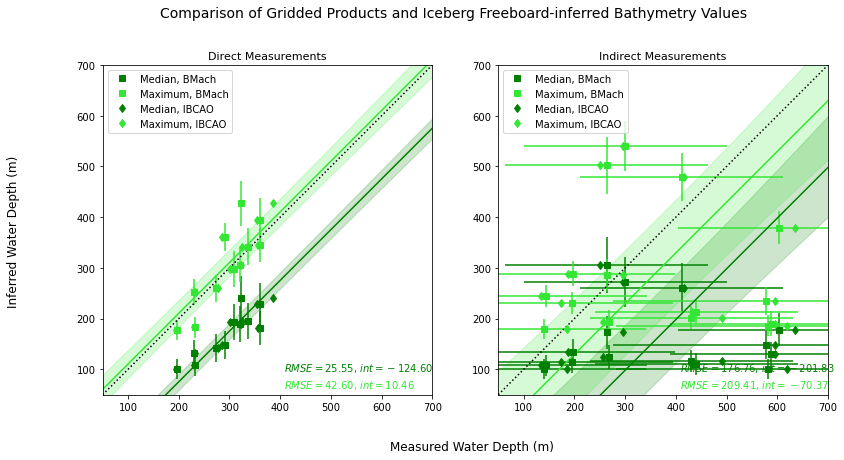

In [98]:
ibplot.meas_vs_infer_fig(gdf, save=False)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
%matplotlib inline

In [ ]:
ds

In [ ]:
from scipy.interpolate import griddata

In [ ]:
all_bathy.x[0:10]

In [ ]:
x = np.arange(5, 8, 0.1)
y = np.arange(-5, 5, 0.1)
xx, yy = np.meshgrid(x, y)

print(len(x))
print(len(y))
print(len(xx))
print(len(yy))
print(x)
print(xx)
print(y)
print(yy)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
h = plt.contourf(x,y,z)
plt.show()


In [ ]:
# xi = np.linspace(int(all_bathy.x.min().item()), int(all_bathy.x.max().item()), int(abs((int(all_bathy.x.min().item())-int(all_bathy.x.min().item())/2))))
res = 2
xmin = all_bathy.x.min().item()
xmax = all_bathy.x.max().item()
xi = np.linspace(xmin, xmax, int(np.round(abs((xmin-xmax)/res))+res/2))
print(len(xi))
ymin = all_bathy.y.min().item()
ymax = all_bathy.y.max().item()
yi = np.linspace(ymax, ymin, int(np.round(abs((ymin-ymax)/res))+res/2))
print(len(yi))
print(np.shape(xi))
print(np.shape(yi))
xi,yi = np.meshgrid(xi, yi)
print(len(xi))
print(len(yi))
print(np.shape(xi))
print(np.shape(yi))

# np.round(abs((int(all_bathy.x.min().item())-int(all_bathy.x.min().item())/2)))

In [ ]:
all_bathy.values.flatten()

In [ ]:
obs = -ds.bmach_bed.where(ds.bmach_source>=10)
meas_only = obs.where(ds.land_mask==1, other=0)
all_bathy = ds.inf_bergs.where(~np.isnan(ds.inf_bergs), other=meas_only)

# xi = np.linspace(int(all_bathy.x.min().item()), int(all_bathy.x.max().item()), int(abs((int(all_bathy.x.min().item())-int(all_bathy.x.min().item())/2))))
# yi = np.linspace(int(all_bathy.y.min().item()), int(all_bathy.y.max().item()), int(abs((int(all_bathy.y.min().item())-int(all_bathy.y.min().item())/2))))
# xi,yi = np.meshgrid(all_bathy.x, all_bathy.y)
print(len(xi))
print(len(yi))
print(len(all_bathy.x))
print(len(all_bathy.y))
print(np.shape([all_bathy.x.values, all_bathy.y.values]))
print(np.shape(all_bathy.values))

interp = griddata((xi.flatten(), yi.flatten()), all_bathy.values.flatten(), (xi, yi), method='linear')

print(type(interp))
plt.imshow(interp, cmap=bathy_cmap)
# all_bathy.plot.imshow(cmap=bathy_cmap)

In [ ]:
Ideas to speed it up but still interpolate:
    - lower resolution for output
    - limit interpolation to area where data is being added (probably a good thing to do for plotting anyway;
                                                            could create a sub-dataset of the area that has new data)
    - find another method (or chunk it)? Since this one crashed the kernel...

In [ ]:
ds.inf_bergs.fillna(0.0).plot.imshow()

In [ ]:
loc = ['Ilulissat Isfjord']
letters=['a','b']
plot_title = 'Comparison of Measured and Inferred Bathymetry Values'

plt.close(fig)

fig, axes = plt.subplots(1,2, figsize=(12,5)) #8,3

#define range of colors for plotting
v=np.linspace(0,600,13)
bathy_cmap = LinearSegmentedColormap.from_list('bathy_cmap', [(0.85,0.9,0.98),(0,0,.5)], 12)   #plt.cm.Blues

# left plot (contours from measurements only)
obs = -ds.bmach_bed.where(ds.bmach_source>=10)
meas_only = obs.where(ds.land_mask==1, other=0)
CS = xr.plot.contour(meas_only, x='x', y='y', ax=axes[0], linewidths=0.3, colors=[(0.95,0.95,0.95)], add_labels=False)
CS = xr.plot.contourf(meas_only, x='x', y='y', ax=axes[0], levels=v, cmap=bathy_cmap, add_labels=False)

In [ ]:
# add iceberg-inferred depths to xarray (ds) as a raster layer
from geocube.api.core import make_geocube

gdf["geometry"] = gdf.geometry
inf_bergs = make_geocube(vector_data=gdf,
                         measurements=['filtered_draft_med'],
                         like=ds,
                         fill=np.nan
                        )

ds["inf_bergs"] = inf_bergs.filtered_draft_med

In [ ]:
# right plot: contours from inferred points and measured points
# Note: currently this uses the iceberg-inferred water depth for the entire area of the iceberg, rather than a single point
all_bathy = ds.inf_bergs.where(~np.isnan(ds.inf_bergs), other=meas_only)
CS2 = xr.plot.contour(all_bathy, x='x', y='y', ax=axes[1], linewidths=0.3, colors=[(0.95,0.95,0.95)], add_labels=False)
CS2 = xr.plot.contourf(all_bathy, x='x', y='y', ax=axes[1], levels=v, cmap=bathy_cmap, add_labels=False)

In [ ]:
# add land and measured bathymetry extent
# plot formatting
landcmap = LinearSegmentedColormap.from_list('land_cmap', [(0.65,0.45,0.35,1),(1,1,1,0)], 2)

for n in range(0,2):
    land = ds.land_mask.fillna(0.0).plot.imshow(x='x', y='y', ax=axes[n], cmap=landcmap, zorder=30, add_labels=False)
    land.colorbar.remove()
    xr.plot.contour(ds.bmach_source, x='x', y='y', ax=axes[n], levels=[0,10,100], linewidths=1, colors='black', add_labels=False)
    
    axes[n].axis('equal')
#     axes[n].set_ylim(ymin,ymax)
#     axes[n].set_xlim(xmin,xmax)

In [ ]:
# update plot labels, etc.
CS.colorbar.remove()
# CS2.colorbar.remove()

#turn off y axis labels
axes[1].yaxis.set_ticklabels([])

#label each plot
axes[0].set_title('measured', fontsize=11)
axes[0].text(0.02, 0.95, letters[0], weight='bold', transform=axes[0].transAxes, zorder=10)
axes[1].set_title('measured+inferred', fontsize=11)
axes[1].text(0.02, 0.95, letters[1], weight='bold', transform=axes[1].transAxes, zorder=10)

fig.text(0.5, 0.03,'Easting (m)', ha='center', va='center', fontsize=12)
fig.text(0.03, 0.5,'Northing (m)', ha='center', va='center', rotation='vertical', fontsize=12)

plt.suptitle('Bathymetry Contours', fontsize=14)
fig.subplots_adjust(hspace=0.3, wspace = 0.14, top=0.87, left=0.14, right=0.87, bottom=0.1)


In [ ]:
fig

In [ ]:
# NEXT STEPS:
# try doing this in holoviews to see if it is faster (especially to layer the plots) --> not at first attempt
# fix the 0/nodata issue so that it uses the available data to contour where possible (but doesn't contour to 0)
# move this plot creation into plot.py and just run it here to get the output

## Export the iceberg outlines and data to a shapefile

In [ ]:
shpgdf = gdf.copy(deep=True)
shpgdf['year'] = shpgdf['date'].dt.year.astype(int)

del shpgdf['date']
del shpgdf['DEMarray']
del shpgdf['filtered_draft']

# NOTE: need to rename columns due to name length limits for shapefile; otherwise,
# all ended up as "filtered_#"

shpgdf.to_file("/Users/jessica/projects/bathymetry_from_bergs/prelim_results/icebergs_JI.shp")

## Visualize the range of elevation (area) values for a single iceberg (DEM)

In [ ]:
vals = gdf[gdf['date'].dt.year.astype(int)==2016].geometry.area

In [ ]:
axHist = plt.subplot()

_ = axHist.hist(vals, np.arange(50000,300000,25000), color="silver")

axHist.set_xlabel('Elevation (m)')
axHist.set_ylabel('Count')
axHist.set_title('DEM Pixel Elevations')

plt.show()

## Visualizing Iceberg Outlines for a Single DEM
Some attempts at doing this with Holoviews, including to try and have it with a slider bar, are in the misc_dev_notes_notebook, as is code for plotting a histogram of iceberg areas (originally meant to be part of the below plot and not updated to be independent)

In [ ]:
timei=1
print(ds['dtime'].isel({'dtime':timei}))
dem = ds.isel({'dtime':timei})

In [ ]:
im = dem.elevation.values

In [ ]:
# Plot objectives: show DEM, land mask, iceberg outlines. 2nd plot with just orig DEM?
fig = plt.figure(figsize=(12,12)) # width, height in inches
# gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
gs=fig.add_gridspec(3,1, hspace=0.3) # nrows, ncols

# DEM plot
axDEM = plt.subplot(gs[0:2,0])
dem.elevation.plot.pcolormesh(ax=axDEM, 
                              vmin=-10, vmax=75, cmap='magma', # vmin and vmax set the colorbar limits here
                              xscale='linear', yscale='linear',
                              cbar_kwargs={'label':"Elevation (m amsl)"})

# land mask
landcm = mpl.colors.ListedColormap([(0.5, 0.35, 0.35, 1.), (0.5, 0., 0.6, 0)])
dem.land_mask.plot(ax=axDEM, cmap=landcm, add_colorbar=False)

# iceberg contours - ultimately add this from geodataframe
# dem.elevation.plot.contour(ax=axDEM, levels=[threshold], colors=['gray'])
# Note: dem.elevation.plot.contour(levels=[threshold], colors=['gray']) will show the plot, but you can't
# add it to these axes and then show it inline from a second cell
# I'm not entirely sure this is plotting what I think; it's also not actually plotting the contoured data 
gdf.loc[gdf['date']==ds.dtime.isel({'dtime':timei}).values].berg_poly.plot(ax=axDEM,
                                                                          linestyle='-',
                                                                          linewidth=2,
                                                                          edgecolor='gray',
                                                                          facecolor=(0,0,0,0))


xmin = -250000
xmax = -232750
ymin = -2268250
ymax = -2251000
# xmin = -235000 #zoom in to figure out empty iceberg DEM during gdf generation
# xmax = -233000
# ymin = -2257500
# ymax = -2255000
while (xmin-xmax) != (ymin-ymax):
    print("modify your x and y min/max to make the areas equal")
    break
    
axDEM.set_aspect('equal')
axDEM.set_xlim(xmin, xmax)
axDEM.set_ylim(ymin, ymax)

axDEM.set_xlabel("x (km)")
axDEM.set_ylabel("y (km)")


plt.show()

In [ ]:
# Note: gdf['date']==timei is returning all false, so the datetimes will need to be dealt with to get the areas from the geometry column
# areas = gdf.loc[:, gdf['date']==timei].geometry.area()